In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
import re
import matplotlib.pyplot

from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.data import load
from nltk.corpus import wordnet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

## 1. Loading of the data

In [114]:
train_df = pd.read_csv('train2.csv')
test_df = pd.read_csv('test2.csv')

In [115]:
train_df.head()

,ID,BODY,TITLE
0,0,"First Pennsylvania Bank N.A., the\nmajor subsi...",FIRST PENNSYLVANIA <FBA> TO LAUNCH NEW VISA CARD
1,1,"Daiwa Securities America Inc, wholly\nowned by...",DAIWA SECURITIES BUYS TORONTO EXCHANGE SEAT
2,2,European Community (EC) industry\nministers to...,EC MINISTERS AGREE NEED FOR BIG STEEL CLOSURES
3,3,International Business Machines\nCorp said it ...,IBM <IBM> ANNOUNCES PRICE CHANGES FOR SYSTEM/38
4,4,Lotus Development Corp said it\nwill extend it...,LOTUS <LOTS> EXTENDS SYMPHONY UPGRADE


In [116]:
train_df[train_df['BODY'].isna()].count()

ID       0
BODY     0
TITLE    0
dtype: int64

Title lengths are right-skewed normally distributed and body lengths are exponentially distributed

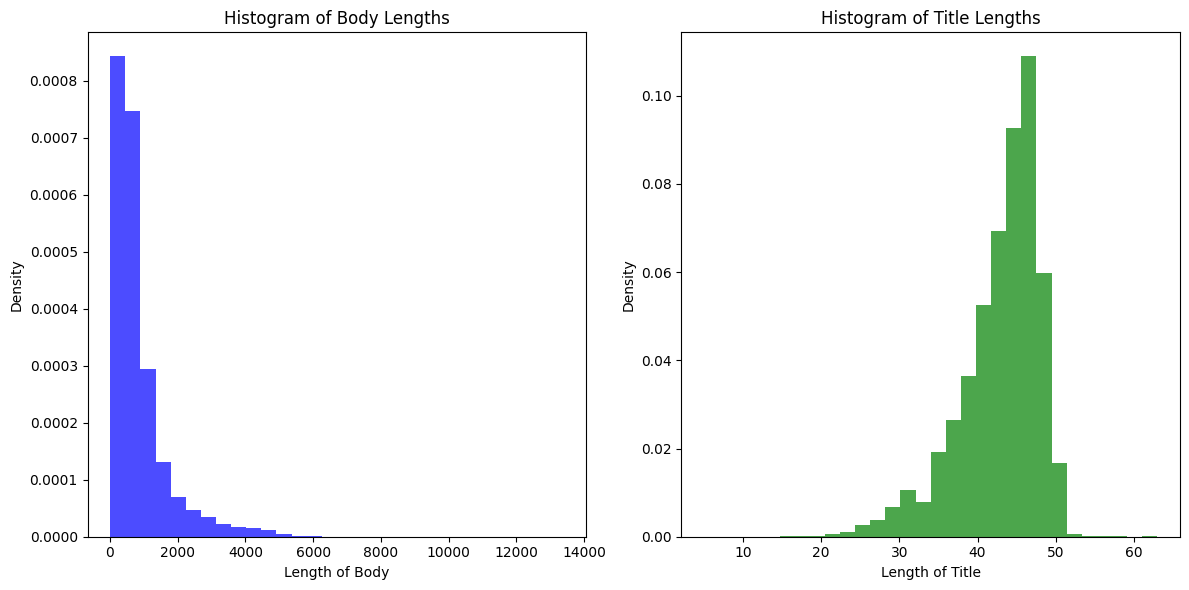

In [117]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_df['BODY'].apply(len), bins=30, density=True, alpha=0.7, color='blue')
plt.title('Histogram of Body Lengths')
plt.xlabel('Length of Body')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(train_df['TITLE'].apply(len), bins=30, density=True, alpha=0.7, color='green')
plt.title('Histogram of Title Lengths')
plt.xlabel('Length of Title')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

We see that there is threshold to the length of the titles, which is around 55, regardless of the length of the body. So it might be good to truncate bodies having length superior to 3000, to make the model more robust. 

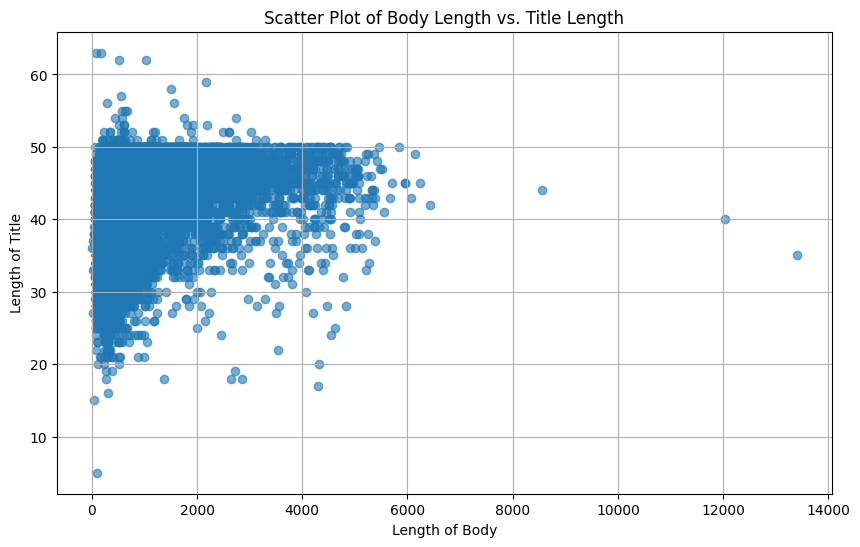

In [118]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['BODY'].apply(len), train_df['TITLE'].apply(len), alpha=0.6)
plt.title('Scatter Plot of Body Length vs. Title Length')
plt.xlabel('Length of Body')
plt.ylabel('Length of Title')
plt.grid(True)
plt.show()

## 2. First Processing of the features

In [119]:
stop = set(stopwords.words("english"))
punctuation = set(string.punctuation)
lemma = WordNetLemmatizer()
treetags = load('help/tagsets/upenn_tagset.pickle').keys()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

In [120]:
def is_abbreviation(word):
        return all(char.islower() or char == '.' for char in word)

def process_sent(sent, title=False, list_of_list_format=True):
    if title:
        sent = re.sub(r'\s*\<.*?\>\s*', ' ', sent)
    sent = sent.strip().lower().split()
    words = [word.strip(string.punctuation) for word in sent]
    cleaned_sent = [lemma.lemmatize(word, get_wordnet_pos(pos)) for (word, pos) in pos_tag(words) if ( (is_abbreviation(word) or word.isalpha()) and word not in stop and word not in punctuation)]
    if list_of_list_format:
        return cleaned_sent
    else:
        return " ".join(word for word in cleaned_sent)

In [121]:
train_df['TITLE'] = train_df['TITLE'].apply(lambda x : process_sent(x, title=True))

In [122]:
train_df['BODY'] = train_df['BODY'].apply(lambda x : process_sent(x))

In [123]:
train_df.head()

,ID,BODY,TITLE
0,0,"[first, pennsylvania, bank, n.a, major, subsid...","[first, pennsylvania, launch, new, visa, card]"
1,1,"[daiwa, security, america, inc, wholly, own, d...","[daiwa, security, buy, toronto, exchange, seat]"
2,2,"[european, community, ec, industry, minister, ...","[ec, minister, agree, need, big, steel, closure]"
3,3,"[international, business, machine, corp, say, ...","[ibm, announces, price, change]"
4,4,"[lotus, development, corp, say, extend, lotus,...","[lotus, extend, symphony, upgrade]"


## 3. Training the Skip-Gram Word2Vec model on our dataset

In [124]:
combined_sentences = [sublist for pair in zip(train_df['BODY'], train_df['TITLE']) for sublist in pair]
w2v_model = Word2Vec(combined_sentences, vector_size=100, window=5, min_count=2, workers=4)

Lets compute the most similar words for "crisis" to see if the model is giving coherent vectors or not

In [125]:
similar_words = w2v_model.wv.most_similar('crisis', topn=10)
print(similar_words)

[('problem', 0.8688488602638245), ('situation', 0.8471527695655823), ('solution', 0.844022810459137), ('stance', 0.8418841361999512), ('difficulty', 0.8283399343490601), ('serious', 0.7950641512870789), ('attitude', 0.7615891098976135), ('strategy', 0.7564557790756226), ('clearly', 0.7533391714096069), ('tough', 0.7518043518066406)]


We get the weights ( or embedded vocabulary vectors ) and word to index mapping for the model so it can embed the sentences

In [126]:
# Assuming w2v_model.vector_size is the dimension of your embeddings
embedding_dim = w2v_model.vector_size

# Existing embeddings
weights_w2v_model = w2v_model.wv.vectors  # Word vectors

# Add embeddings for UNK, PAD, EOS, and SOS
unk_vector = np.random.rand(embedding_dim)  # or np.mean(weights_w2v_model, axis=0) for average
pad_vector = np.zeros((embedding_dim,))
sos_vector = np.random.rand(embedding_dim)
eos_vector = np.random.rand(embedding_dim)

# Combine all embeddings
weights_tensor = np.vstack([weights_w2v_model, unk_vector, pad_vector, eos_vector, sos_vector])
weights_tensor = torch.FloatTensor(weights_tensor)

print("Shape of the weights (Vocabulary Size, Dimension of vectors):", weights_tensor.shape)

Shape of the weights (Vocabulary Size, Dimension of vectors): torch.Size([20366, 100])


In [127]:
SOS_token = "<SOS>"
EOS_token = "<EOS>"
UNK_token = "<UNK>"
PAD_token = "<PAD>"

word_to_index = {word: index for index, word in enumerate(w2v_model.wv.index_to_key)}
word_to_index[UNK_token] = len(word_to_index)
word_to_index[PAD_token] = len(word_to_index)
word_to_index[SOS_token] = len(word_to_index)
word_to_index[EOS_token] = len(word_to_index)
index_to_word = {index: word for (word, index) in word_to_index.items()}

def add_sos_eos_token(sentence):
    sent = [SOS_token]
    sent = sent + sentence
    sent = sent + [EOS_token]
    return sent
    
def sentence_to_indices(sent, word_to_index, eos=True, sos=False):
    return [word_to_index.get(word, word_to_index.get("<UNK>")) for word in sent]

def indices_to_words(indices, index_to_word):
    return [index_to_word.get(index, "<UNK>") for index in indices]

## 4. Second Processing of the features

We add start of sentence and end of sentence token so its easier for the model to learn. We pad/truncate the titles so they are all the same length and truncate the texts to speed up the training

In [128]:
# Add SOS , EOS tokens to the titles
train_df['TITLE'] = train_df['TITLE'].apply(lambda sent: add_sos_eos_token(sent))

# Convert the sentences in 'BODY' and 'TITLE' columns to indices
train_df['BODY_IDX'] = train_df['BODY'].apply(lambda sent: sentence_to_indices(sent, word_to_index))
train_df['TITLE_IDX'] = train_df['TITLE'].apply(lambda sent: sentence_to_indices(sent, word_to_index, sos=True))

# Find the maximum length for padding
max_len_body = 50
max_len_title = 10

# Pad the sequences
def pad_or_truncate(sequence, max_len):
    if len(sequence) > max_len:
        # Truncate the sequence if it's longer than max_len
        return sequence[:max_len]
    else:
        padding = [word_to_index[PAD_token]] * (max_len - len(sequence))
        return sequence + padding

# Apply padding or truncation
train_df['BODY_IDX_PADDED'] = train_df['BODY_IDX'].apply(lambda x: pad_or_truncate(x, max_len_body))
train_df['TITLE_IDX_PADDED'] = train_df['TITLE_IDX'].apply(lambda x: pad_or_truncate(x, max_len_title))


## 5. Building the Seq2Seq model

To generate headlines from a given text, we use an Encoder/Decoder architecture, with both components implemented as LSTMs.

Overview of the Process:

1. **The Encoder**: 
    - Responsible for encoding the information contained in the input text.

    - Takes the text as input and outputs two vectors: the hidden state and the cell state, which carry the encoded information.

2. **The Decoder**: 
    - Generates the probability distribution over the vocabulary and produces new hidden/cell states.
    
    - Can use either the information from the Encoder or its own output from the previous iteration.

3. **Seq2Seq Model**: 
    - A combination of the Encoder and Decoder.

    - Responsible for generating the title in the form of a probability distribution, given an input text.

4. **Training the Seq2Seq Model with Teacher Forcing**:
    - Iterate through titles in the training set, breaking them down into tokens.

    - In each iteration:

        - Feed a new token from the current title and the hidden/cell state (from the previous iteration or the Encoder if it's the first iteration) to the Decoder.
        - The Decoder outputs a probability distribution over the vocabulary and new hidden/cell state, which are stored in a tensor.
        - Repeat until there are no more tokens in the title.
        - The resulting tensor has the shape `(batch_size, sequence_length, vocabulary_size)`.
        - Compute the cross-entropy loss using this output and the true words.

        - Backpropagate and update the Seq2Seq model parameters.

5. **Inference Process**:
    - Without available titles (as in training), we use the previously predicted probability distribution to generate new tokens.
    - For each new token, either sample from the distribution or choose the token with the highest probability.
    
    - Continue this process to generate a complete title.


In [129]:
class EncoderLSTM(nn.Module):
    def __init__(self, hidden_size, pre_trained_emb, num_layers=1, dropout=0.5):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)
        self.num_layers = num_layers
        self.lstm = nn.LSTM(pre_trained_emb.shape[1], hidden_size, num_layers, dropout=dropout, batch_first=True)
        
    def forward(self, input_seq):
        embedded = self.embedding(input_seq) # tensor of shape (batch_size, sequence_length, embedding_dimension)
        output, (hidden, cell) = self.lstm(embedded) # output is of size (batch_size, sequence_length, hidden_size)
        return hidden, cell # tensors of shape (num_layers, batch_size, hidden_size)

class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, pre_trained_emb, num_layers=1, dropout=0.5):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)
        self.lstm = nn.LSTM(pre_trained_emb.shape[1], hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, pre_trained_emb.shape[0])

    def forward(self, input, hidden, cell):
        # input shape: (batch_size,)
        embedded = self.embedding(input).unsqueeze(1)  # Reshape (batch_size, embedding_dim) to (batch_size, 1, embedding_dim)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # output shape: (batch, 1, hidden_size)
        prediction = self.fc_out(output.squeeze(1))  # Reshape to (batch_size, vocab_size)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, body_input, target_title):
        batch_size = body_input.shape[0]
        vocab_size = self.decoder.embedding.num_embeddings
        target_length = target_title.shape[1] # target_title is of shape (batch_size, sequence_length)
        
        outputs = torch.zeros(batch_size, target_length, vocab_size)
        hidden, cell = self.encoder(body_input)

        # The first input to the decoder is the <SOS> token from target_title
        input = target_title[:, 0]

        for t in range(1, target_length):
            prediction, hidden, cell = self.decoder(input, hidden, cell) # prediction is of shape (batch_size, vocabulary_size)
            outputs[:, t, :] = prediction

            # Next input is the token of the target_title
            input = target_title[:, t]

        return outputs

## 6. Training

In [130]:
# Convert to PyTorch tensors
feature1 = 'BODY_IDX_PADDED'
feature2 = 'TITLE_IDX_PADDED'
body_tensors = torch.tensor(list(train_df[feature1].values), dtype=torch.long)
title_tensors = torch.tensor(list(train_df[feature2].values), dtype=torch.long)

# Create dataset and dataloader
dataset = TensorDataset(body_tensors, title_tensors)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Note on how PyTorch `nn.CrossEntropyLoss` :

1. **Model's Output and Reshaping**
The Seq2Seq model outputs logits, representing unnormalized predicted scores for each word in the vocabulary, for every token in each sequence. The output shape is `[batch_size, sequence_length, vocab_size]`. To align with `nn.CrossEntropyLoss`, we reshape this tensor to `[batch_size * sequence_length, vocab_size]`. Correspondingly, the target tensor, which contains indices of the actual words in the titles, is reshaped from `[batch_size, sequence_length]` to `[batch_size * sequence_length]`. This is crucial because `nn.CrossEntropyLoss` treats each token position across all sequences as an independent example.

2. **Softmax Application**
`nn.CrossEntropyLoss` computes the softmax of these logits along the last dimension (`vocab_size`). The softmax operation transforms each logit vector into a probability distribution across the vocabulary for each token.

3. **Loss Computation per Token**
For each token, the loss function retrieves the probability of the true class based on the target tensor. For example, if the true class for a specific token is indexed as `45`, the function accesses the 45th element in the softmax output vector to obtain the model's predicted probability for that class. 

4. **Negative Log-Likelihood**
The function then computes the negative logarithm of these probabilities, representing the individual loss for each token position.

5. **Average Loss Calculation**
If `reduction='mean'` is set (the default), the function averages these individual losses across all token positions in the batch to compute the total loss. This total loss is a measure of how well the model's predictions align with the actual words across all positions in all sequences in the batch.



In [ ]:
hidden_size = 32

# Initialize the encoder and decoder with the pre-trained embeddings
encoder = EncoderLSTM(hidden_size, weights_tensor, num_layers=1, dropout=0)
decoder = DecoderLSTM(hidden_size, weights_tensor, num_layers=1, dropout=0)

# Create the Seq2Seq model
seq2seq = Seq2Seq(encoder, decoder)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<PAD>"]) 
optimizer = optim.Adam(seq2seq.parameters())

num_epochs = 10  # Number of epochs

seq2seq.train()  # Set the model to training mode

for epoch in range(num_epochs):
    total_loss = 0

    for body_seqs, title_seqs in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Pass both body and title sequences through the model
        output = seq2seq(body_seqs, title_seqs)

        # Reshape output for loss calculation
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        title_seqs_flattened = title_seqs.reshape(-1)

        # Calculate loss
        loss = criterion(output, title_seqs_flattened)
        total_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')


## 7. Evaluating